## Some exercise ideas with Loic's accelerator tools

Below is a composition of some exercise ideas how we could use them in the class. For now the code is complete and you should be able to run it (once you include the changes that I made to Loic's accelerator toolbox). For the actual exercise, we will remove some of the inputs, formulas and maybe replace some of it with additional hints. I added quite some text already to give an idea how I think it could look in the end. Feel free to add more ideas.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../accelerator/'))

In [ ]:
from accelerator.elements.quadrupole import Quadrupole
from accelerator.elements.drift import Drift
from accelerator.lattice import Lattice
from accelerator import Beam

import numpy as np
import matplotlib.pyplot as plt

## Ex. 1: FODO
### a) Beta functions in a FODO cell

<div>
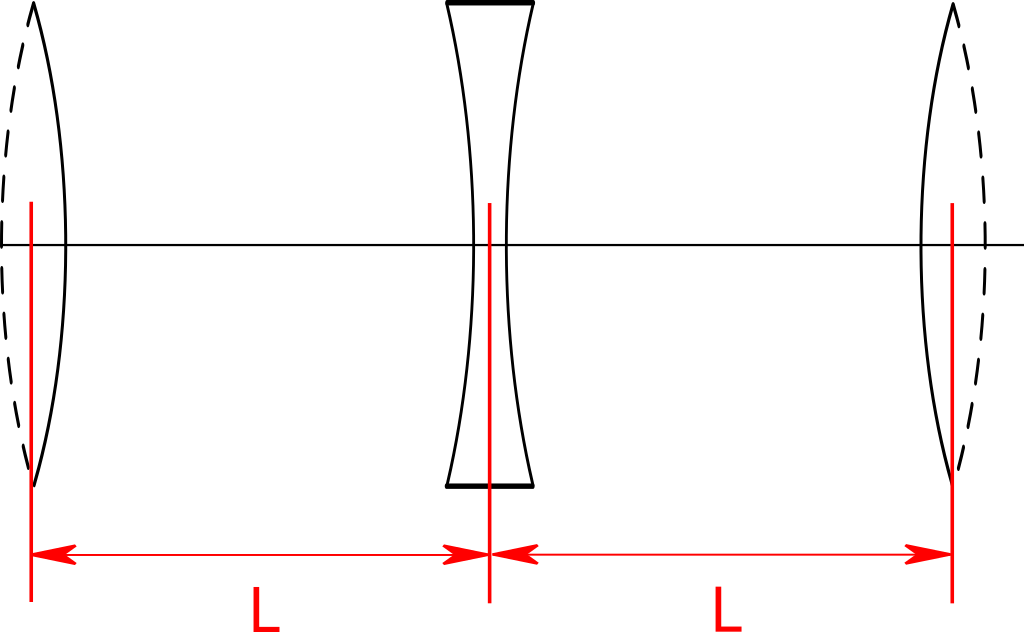
</div>

**Exercise**  
Construct the FODO cell shown above using thin Quadrupoles and Drift elements with f = +/-0.8 m and L = 1 m, resp.  
*(here we'll have to decide what gaps to let them fill in. Or give an example of 1 thin Quad and a Drift so that they have a template on how to make the `lattice`)*



**Step 0**: Initialize beam

In [ ]:
beam = Beam()

**Step 1**: Define basic components of the FODO cell
- Drift spaces of length L each
- Focusing quadrupoles at half strength (i.e. double focal length!)
- Defocusing quadrupole

In [ ]:
f = 0.8  # focal length (m)
L = 1.  # drift length (m). Note FODO total length: 2L

half_quad_F = Quadrupole(2.*f)
quad_D = Quadrupole(-f)
drift = Drift(L)

**Step 2**: Define the lattice  
Put the elements into a list in the correct order

In [ ]:
FODO = [half_quad_F, drift, quad_D, drift, half_quad_F]

N_cells = 1  # Can increase to make lattice with many FODO cells
lattice = Lattice(N_cells*FODO)

**Step 3** (optional): Slice up the drifts into smaller pieces to show quadratic nature of beta functions

In [ ]:
n_slices = 20
lattice = lattice.slice(Drift, 20)

**Step 4**: Calculate the initial Twiss conditions of the cell for the horizontal and vertical planes. They define the correct, periodic solution of the FODO.  

Some hints:  
- Compute first the phase advance of the cell based on L and f:  
$\psi_{cell} = \arccos \left( 1 - \frac{L^2}{2 f^2}\right)$
- We can calculate the minimum and maximum $\beta$-functions using
$\beta_{\pm} = \frac{2 L}{\sin \psi_{cell}} \left(1 \pm \sin \frac{\psi_{cell}}{2}\right)$  
- Remember that the horizontal (vertical) beta function at the center of the focusing (defocusing) quadrupole is maximum $\beta_{+}$ (minimum $\beta_{-}$).
- Furthermore, $\gamma_{x,y} = \frac{1 + \alpha_{x,y}^2}{\beta_{x,y}}$
- We know that $\alpha_{x,y}$ at the center of the quadrupole is 0.

With these hints you can compute $\beta_{(x,y),0}$, $\alpha_{(x,y),0}$, and $\gamma_{(x,y),0}$.

In [ ]:
# FODO phase advance
psi_cell = np.arccos(1. - L**2 / (2.*f**2))

# Calc. periodic Twiss solutions
beta_x0 = 2.*L / np.sin(psi_cell) * (1. + np.sin(psi_cell / 2.))
gamma_x0 = 1./beta_x0
beta_y0 = 2.*L / np.sin(psi_cell) * (1. - np.sin(psi_cell / 2.))
gamma_y0 = 1./beta_y0

**Step 5**: Transport the beam through the FODO lattice in both transverse planes using above initial conditions  
- For now we are interested in the Twiss parameters along the lattice (i.e. vs. `s`).  
- Note that `s_x == s_y`

In [ ]:
*twiss_x, s_x = lattice.transport([beta_x0, 0, gamma_x0], plane='h')
*twiss_y, s_y = lattice.transport([beta_y0, 0, gamma_y0], plane='v')

**Step 6**: Plot the results!

In [ ]:
# Beta functions
beta_x = twiss_x[0]
beta_y = twiss_y[0]

plt.figure(1, figsize=(7, 5))
plt.plot(s_x, beta_x, label=r'Horizontal')
plt.plot(s_y, beta_y, label=r'Vertical')
plt.xlabel(r's (m)')
plt.ylabel(r'$\beta$ (m)')
plt.legend()
plt.ylim(bottom=0.)
plt.show()

**Step 7**: Change the parameters and rerun to see how the beta functions change  
For example  
- How do $\beta_{x,y}$ change when you increase / decrease f, or L?
- FODO stability: why does the code complain, or show a warning, when you set, for example, f = 0.2 m, keeping L = 1 m? Based on what you know from the lectures - what formal condition on f and L needs to be fulfilled to have a well-defined FODO cell (solution: $\frac{2 L}{4} < f$).
- Change also the number of FODO cells: `N_cells` to illustrate the periodicity of the beta-functions vs. `s`.

### b) Phase space evolution in a FODO cell

Using the ideas from the example above, let's now find out how the phase space evolves in a FODO cell. We want to visualize the phase space ellipse of the beam at various places in the FODO. In particular
1. at the center of the first focusing half-quad.
2. just after the focusing half-quad.
3. after the first drift (before the defocusing quad.)
4. at the center of the defosing quad.
5. just after the defocusing quad.
6. after the second drift
7. at the center of the final focusing half-quad.  

In this exercise we aim to qualitatively reproduce the two rows of images of the phase space ellipses in the image (top and bottom rows correspond to horizontal and vertical phase spaces, respectively)

<div>
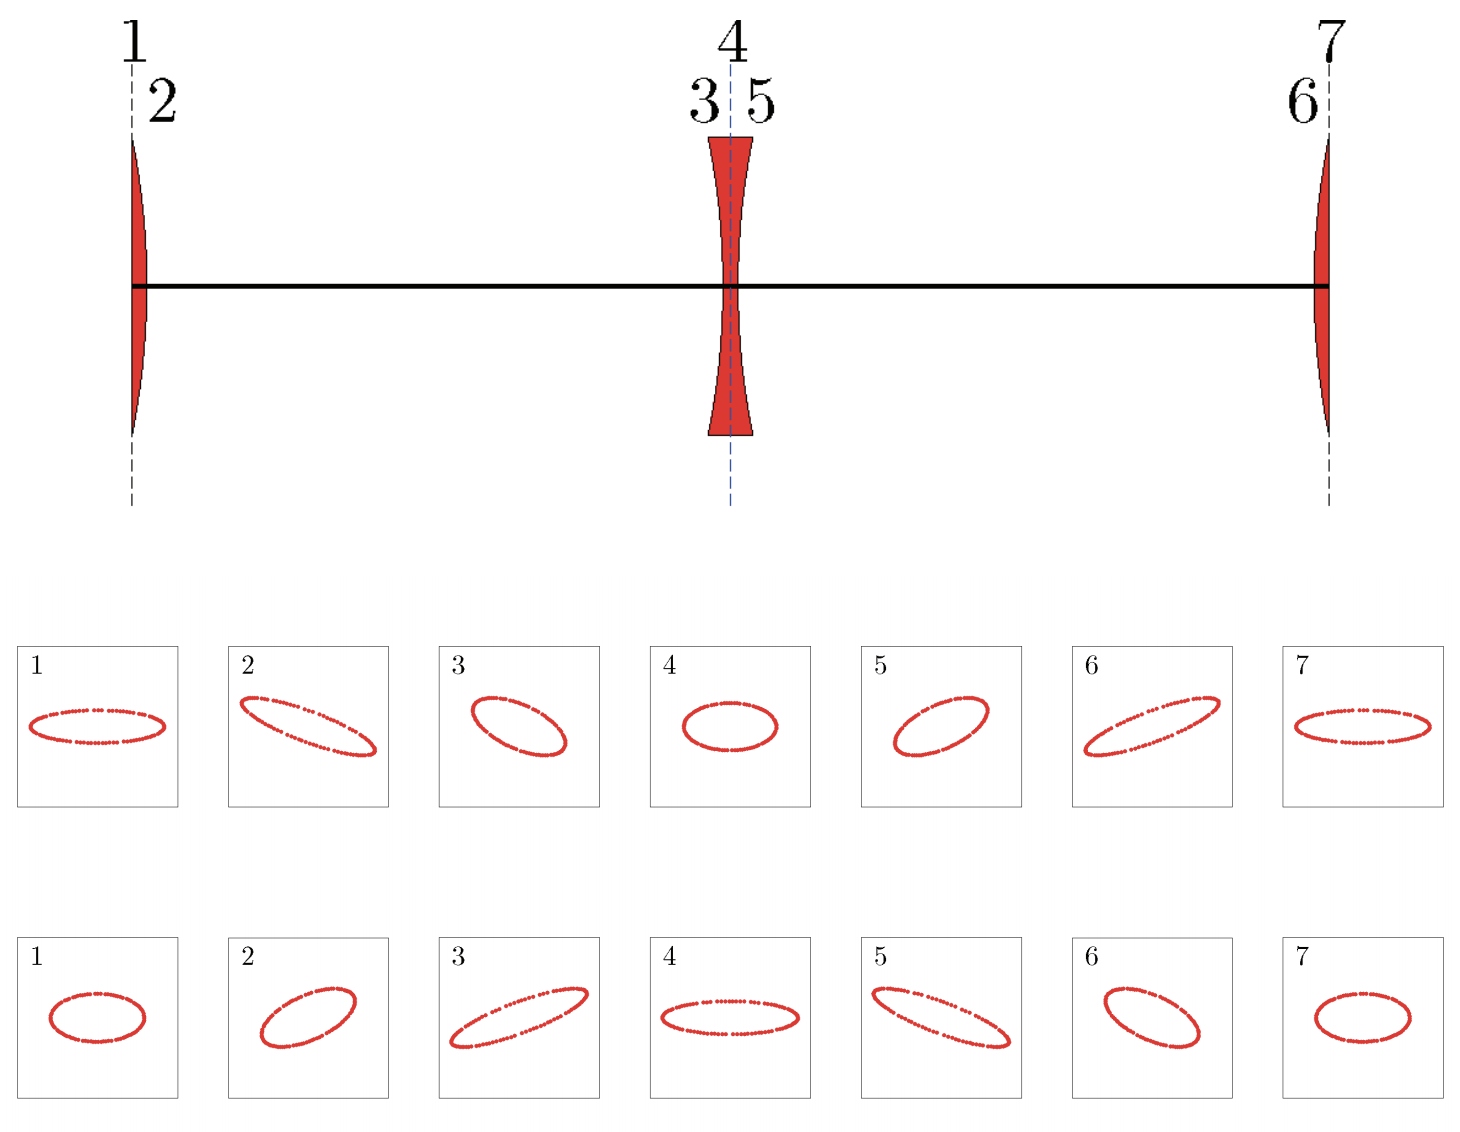
</div>
From: http://pcwww.liv.ac.uk/~awolski/Teaching/Cockcroft/LinearDynamics/LinearDynamics-Lecture6.pdf (slide 21)

**Step 0**: Initialize beam

In [ ]:
beam = Beam()

**Step 1**: Modified FODO

The `lattice.transport` method will output the phase space ellipses at the different places in the lattice. As we want to now the state of the phase space *also at the center of the defocusing quadrupole*, we need to slightly modify our lattice compared to exercise 1 a), and split the defocusing quad. into two halves to make sure we have access to the phase space ellipse at this location.

In [ ]:
f = 0.8  # focal length (m)
L = 1.  # drift length (m). Note FODO total length: 2L

half_quad_F = Quadrupole(2.*f)
half_quad_D = Quadrupole(-2.*f)
drift = Drift(L)

FODO = [half_quad_F, drift, half_quad_D,
        half_quad_D, drift, half_quad_F]
lattice = Lattice(FODO)

**Step 2**: Initial Twiss conditions  
Just as above, we need to calculate the Twiss parameters at the beginning of the FODO cell to make sure we fulfil the periodicity conditions.

In [ ]:
# FODO phase advance
psi_cell = np.arccos(1. - L**2 / (2.*f**2))

# Calc. periodic Twiss solutions
beta_x0 = 2.*L / np.sin(psi_cell) * (1. + np.sin(psi_cell / 2.))
gamma_x0 = 1./beta_x0
beta_y0 = 2.*L / np.sin(psi_cell) * (1. - np.sin(psi_cell / 2.))
gamma_y0 = 1./beta_y0

**Step 3**: Transport the beam using the computed initial Twiss parameters  
This time we don't care about the Twiss parameters in the FODO, but instead are interested in the evolution of the phase space only. So, we keep only the first two outputs of the `lattice.transport_beam` method. `(x, x_prime)` and `(y, y_prime)` define the phase space ellipse.

In [ ]:
phasespace_ellipse_x = beam.ellipse([beta_x0, 0, gamma_x0])
phasespace_ellipse_y = beam.ellipse([beta_y0, 0, gamma_y0])
x, x_prime, _ = lattice.transport(phasespace_ellipse_x, plane='h')
y, y_prime, _ = lattice.transport(phasespace_ellipse_y, plane='v')

**Step 4**: Plot the results!  

It's important that you don't modify the lattice (order and number of elements) here, otherwise the plots will no longer correspond. You can of course still change parameters `f` and `L`, and are actually encouraged to do so.

In [ ]:
# Define labels and colormap
labels = [
    'Center half F quad.',
    'After half F quad.',
    'After first drift',
    'Center half D quad.',
    'After D quad.',
    'After second drift',
    'Center half F quad.'
]
colmap = plt.get_cmap('plasma')

# Go through the 7 places of the FODO where we want to see phase space
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)

for i in range(7):
    ls = '-'
    if i == 6:
        ls = '--'
    ax1.plot(x[:, i], x_prime[:, i], c=colmap(i/7.), ls=ls)
    ax2.plot(y[:, i], y_prime[:, i], c=colmap(i/7.), ls=ls,
             label=labels[i])
    
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax1.set_xlabel('x (m)')
ax1.set_ylabel("x'")
ax2.set_xlabel('y (m)')
ax2.set_ylabel("y'")
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

**Interpretation / discussion**  
- We see that thanks to the correct initialization of the Twiss parameters (and phase advance of the cell), the solution is indeed periodic (first and last ellipse correspond to each other!).
- Furthermore, thanks to the correct boundary conditions, the ellipse at the center of the *defocusing quadrupole* is not tilted, which corresponds to $\alpha_{x,y} = 0$, as expected at the locations where the $\beta$-functions are minimum / maximum.
- Explain what happens to the ellipse during the first drift. How is the ellipse transformed (think in terms of the drift transport matrix for example)?
- Do the same reasoning for the thin lens quadrules.
- See how `f` and `L` affect the ellipse. What happens if you make `f` too small?

## Tracking and calculation of tunes
### a) Track a single particle through a number of FODO cells

Define a lattice composed of many FODO cells (e.g. 5 - 10). We assume this is a ring accelerator (ignore the fact that we don't have any bending dipoles for a moment). Define some random initial coordinates of a particle and track it through the lattice for many turns.

**Step 0**: Initialize beam

In [ ]:
beam = Beam()

**Step 1**: Set up ring accelerator composed entirely of FODO cells

In [ ]:
N_cells = 5

f = 1.8  # 0.49999  # focal length (m)
L = 1.  # drift length (m). Note FODO total length: 2L

half_quad_F = Quadrupole(2.*f)
quad_D = Quadrupole(-f)
drift = Drift(L)

FODO = [half_quad_F, drift, quad_D, drift, half_quad_F]
lattice = Lattice(N_cells*FODO)

**Step 2**: Track a particle  
Define some initial particle coordinates `(x_0, x_prime_0)` and "install" a fancy horizontal BPM that can record the horizontal phase space coordinates (both x and x_prime) of this particle after every turn. We will use this data in exercise b) to determine the tunes of the machine.  

Since the machine is all linear, every particle will have exactly the same tune. It is hence OK to just track one particle (rather than a full beam) to find out the tunes later in part b).  

Furthermore, since the machine is entirely symmetric between the horizontal and vertical planes, the vertical tune is exactly the same as the horizontal one.

In [ ]:
N_turns = 128

# Initial coordinates
x_0 = 8e-3
x_prime_0 = 3e-4

x = x_0
x_prime = x_prime_0
# Track for N_turns
bpm = []
for t in np.arange(N_turns):
    bpm.append([x, x_prime])
    x, x_prime, _  = lattice.transport([x, x_prime], plane='h')
    x = x[-1]
    x_prime = x_prime[-1]
bpm = np.array(bpm)

**Step 3**: Plot the acquired phase space data  
The coordinates are colour-coded with the number of turns  

*Why is the ellipse not tilted? (Hint: think about where we are recording the BPM data.*

In [ ]:
# For colour coding
plt.figure(1, figsize=(8, 5))
# plt.gca().set_aspect('equal')
sc = plt.scatter(bpm[:, 0], bpm[:, 1], s=20, c=range(N_turns),
                 cmap='viridis')

plt.xlabel('x (m)')
plt.ylabel("x'")
cbar = plt.colorbar(sc)
cbar.set_label('Turn')
plt.show()

**Step 4**: Usually a real BPM cannot record both x and x_prime, but only the position x. Let's see what that signal looks like.

In [ ]:
# For colour coding
plt.figure(1, figsize=(7, 5))
plt.plot(bpm[:, 0], c='b')

plt.xlabel('Turn')
plt.ylabel('x (m)')
plt.show()

**Step 5**: Go back and create a slightly unstable FODO cell (e.g. using L = 1 m and f = 0.4999 m).

*Explain what happens to the particle oscillation amplitude and what that would mean for a real machine.*

### b) Calculate the tune of our FODO lattice  
Using the BPM data that we acquired previously (make sure you work with the stable FODO lattice!), we can now determine the tunes of the lattice and also explore how the tunes change with `f` for example.

**Step 1**: Use numpy fft functions to determine the frequency spectrum of the oscillation. We are using turn-by-turn data, so the frequency already is in correct units (recall the definition of the tune: number of oscillations per revolution)

In [ ]:
amplitude = np.abs(np.fft.rfft(bpm[:, 0]))
frequency = np.fft.rfftfreq(N_turns)

plt.figure(1, figsize=(7, 5))
plt.plot(frequency, amplitude)
plt.xlabel('Tune')
plt.ylabel('|Amplitude| (arb. units)')
plt.show()

**Step 2**: Extract the main tune from the spectrum  
*Hint: determine the frequency that corresponds to the highest amplitude peak in the spectrum*

In [ ]:
print('Horizontal tune:', frequency[np.argmax(amplitude)])

**Additional tasks**:  
- Explore how the tune changes when you change f (see also c) below). When does it increase / decrease? Why?
- Try to find out how to improve the resolution of the frequency spectrum. *Hint: change N_turns and see when you get a smoother result.*
- What happens to the tune when you e.g. double the number of FODO cells?

### c) (optional) Systematic scan of the tune vs.  `f`  

Create a plot that shows tune vs. f. You can wrap the FODO definition, tracking, and extraction of tune from the frequency spectrum into a function that you can then call inside a loop for different values of f (just put the main steps from exercises a) and b) into the function body).

Scan, for example a range of $f \in [0.51, 1]$ m.  

*Maybe we will provide this function with some gaps*

**Step 1**: Implement the `get_tune(f)` function.

In [ ]:
def get_tune(f):
    
    # Define lattice
    N_cells = 5
    L = 1.

    half_quad_F = Quadrupole(2.*f)
    quad_D = Quadrupole(-f)
    drift = Drift(L)

    FODO = [half_quad_F, drift, quad_D, drift, half_quad_F]
    lattice = Lattice(N_cells*FODO)
    
    # Tracking to get BPM data
    N_turns = 256
    # Initial coordinates
    x_0 = 8e-3
    x_prime_0 = 3e-4

    x = x_0
    x_prime = x_prime_0
    # Track for N_turns
    bpm = []
    for t in np.arange(N_turns):
        bpm.append([x, x_prime])
        x, x_prime, _  = lattice.transport([x, x_prime], plane='h')
        x = x[-1]
        x_prime = x_prime[-1]
    bpm = np.array(bpm)
    
    # Frequency / tune analysis
    amplitude = np.abs(np.fft.rfft(bpm[:, 0]))
    frequency = np.fft.rfftfreq(N_turns)

    return frequency[np.argmax(amplitude)]

**Step 2**: Create a loop over different values of `f` to calculate the tune for every case.

In [ ]:
N_scan_values = 20
f_array = np.linspace(0.51, 2., N_scan_values)
tune_array = np.zeros(N_scan_values)

for i, f in enumerate(f_array):
    tune_array[i] = get_tune(f)

**Step 3**: Plot the result!

In [ ]:
plt.figure(1, figsize=(7, 5))
plt.plot(f_array, tune_array, '.b')
plt.xlabel('f (m)')
plt.ylabel('Tune')
plt.show()

**Step 4**: Interpret result  
- Somethings still wrong, need to find out myself what's happening here :) ...

## Emittance conservation  
In absence of acceleration or deceleration, the emittance in a linear machine is a conserved quantity (this can change when collective effects and non-linear elements, such as octupole magnets come into play, but we don't treat these right here). We know that the emittance is defined as the area of the phase space ellipse (aka. Courant-Snyder invariant). However, we can also define a statistical rms emittance according to   $\epsilon_{rms} = \sqrt{\bar{x^2} \bar{x'^2} - \bar{x x'}^2}$

**Step 0**: Define beam and check its emittance  
*Recall the definition of emittance. In particular, what is the difference between normalized and geometric emittance?*

In [ ]:
beam = Beam(n_particles=1000, emittance=3.5e-6)
print('Horizontal normalized emittance (m.rad): ', beam.emittance_h)
print('Horizontal geometric emittance (m.rad): ',
      beam.emittance_h / beam.beta_relativistic / beam.gamma_relativistic)

**Step 1**: Define the lattice (you can use the same as in the previous exercise)

In [ ]:
N_cells = 5

f = 1.8  # 0.49999  # focal length (m)
L = 1.  # drift length (m). Note FODO total length: 2L

half_quad_F = Quadrupole(2.*f)
quad_D = Quadrupole(-f)
drift = Drift(L)

FODO = [half_quad_F, drift, quad_D, drift, half_quad_F]
lattice = Lattice(N_cells*FODO)

**Step 2**: Initialize a *matched* particle distribution  

Matched means that we take into account the Twiss parameters at the location where our lattice starts (that's where we inject the beam!). In this case here, we are starting at the center of the focusing quadrupole (and hence $\alpha_{x,y} = 0$).  

This is identical to transporting the phase space ellipses as in exercise 1. Hence we can reuse the same calculations of phase advance and initial Twiss parameters. Note that we will only consider the horizontal plane here.  

For the particle initialization, we make use of the `beam.matched_particle_distribution` method. You can generate more particles by passing the `n_particles` argument to the `Beam(..)` instantiator in step 0.

In [ ]:
# FODO phase advance
psi_cell = np.arccos(1. - L**2 / (2.*f**2))

# Calc. periodic Twiss solutions
beta_x0 = 2.*L / np.sin(psi_cell) * (1. + np.sin(psi_cell / 2.))
gamma_x0 = 1./beta_x0

In [ ]:
distribution = beam.match(twiss=[beta_x0, 0, gamma_x0], plane='h')

**Step 3**: Visualize the particle distribution

*Think how the distribution would change if we would initialize at a place where $\alpha_x \neq 0$ (i.e. not in the center of a quadrupole for instance).* This will be illustrated in step 5 below.

In [ ]:
plt.figure(1, figsize=(8,5))
plt.gca().set_aspect('equal')
plt.plot(distribution[0], distribution[1], '.b')
plt.xlabel('x (m)')
plt.ylabel("x'")
plt.show()

**Step 4**: Track all particles through the lattice once  

The `phase_space` ndarray contains the phase space coordinates of every particle at every location in the lattice.

In [ ]:
x, x_prime, s = lattice.transport(distribution)

**Step 5**: Consider the phase space distribution at the different locations in the lattice.  

Look at the phase space at different elements in the lattice (change `location_index` from 0, 1, 2, 3... [0: initial location, center of F quad, 1: just after F quad, 2: after first drift, etc.]). How does the particle distribution change? Can you see the similarities with the phase space ellipses transported earlier in exercise 1?

*Would be nice to implement a function that can plot the lattice and add labels / indices which index in the phase_space array corresponds to which location in the lattice*

In [ ]:
# index 4 is e.g. at the end of the second drift in the first FODO cell
location_index = 1

plt.figure(1, figsize=(8,5))
plt.gca().set_aspect('equal')
plt.plot(x[:, location_index], x_prime[:, location_index], '.r')
plt.xlabel('x (m)')
plt.ylabel("x'")
plt.show()

*Here an overview of the passage of the beam through 1 FODO cell*

In [ ]:
fig, axs = plt.subplots(figsize=(10, 3),
                        nrows=2, ncols=3, sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(x[:, i], x_prime[:, i], '.r')
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel("x'")
plt.show()

**Step 6**: Show that although the phase space distribution changes a lot along the lattice (as we have just seen!), the emittance is conserved. To do that, calculate the statistical rms emittance of the particle distribution for every s-position. Recall the definition of the statistical beam emittance given at the beginning of this exercise.  

*Also this one can be made nicer / more understandable*

In [ ]:
emittance_rms = np.sqrt(np.mean(x**2, axis=0)*np.mean(x_prime**2, axis=0) - 
                        np.mean(x*x_prime, axis=0)**2)
emittance_rms = emittance_rms * beam.beta_relativistic * beam.gamma_relativistic

In [ ]:
plt.figure(1, figsize=(7, 5))
plt.plot(s, 1e6*emittance_rms, '.r--', label='Statistical emittance')
plt.gca().axhline(1e6*beam.emittance_h, label='Set emittance')
plt.xlabel('s (m)')
plt.ylabel('Emittance (um.rad)')
# plt.ylim(3, 4)
plt.legend()
plt.show()

print('Average statistical normalized emittance (m.rad): ',
      np.mean(emittance_rms))
print('Set normalized emittance (m.rad): ', beam.emittance_h)

**Additional things to explore**  
- How does the number of particles defined in step 0 affect the calculation of the statistical emittance? Do you expect to be closer or further away from the value we set for the emittance if we increase / decrease the number of particles significantly (e.g. from 1000 to 50'000)?
- Play with the value of emittance. What happens to the beam distribution when you increase / decrease it?

In [ ]:
# UNUSED
# Plot lattice
plt.figure(1, figsize=(10, 3))
ax = plt.gca()

element_styles = {'FQuad': 'dashed', 'DQuad': 'dotted'}

s = 0.
for el in lattice:
    if type(el) == Quadrupole:
        if el.f > 0:
            ls = element_styles['FQuad']
        else:
            ls = element_styles['DQuad']
        ax.axvline(s, ls=ls)
    elif type(el) == Drift:
        pass
    s += el.length
ax.axhline(0.5, color='k', ls='solid')

ax.axes.get_yaxis().set_visible(False)
plt.xlabel('s (m)')
plt.show()